In [2]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from IPython.display import clear_output
from keras.optimizers import Adam
from keras.layers import Conv2D, BatchNormalization, Input, GlobalAveragePooling2D, Dense, Reshape, LeakyReLU
from keras.models import Model, Sequential
from keras.layers import Conv2DTranspose

In [13]:
# function for building the discriminator layers
def build_discriminator(start_filters, spatial_dim, filter_size):
        
    # function for building a CNN block for downsampling the image
    def add_discriminator_block(x, filters, filter_size):
        x = Conv2D(filters, filter_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, filter_size, padding='same', strides=2)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x) #Can try other values
        return x
    
    # input is an image with shape spatial_dim x spatial_dim and 3 channels
    inp = Input(shape=(spatial_dim, spatial_dim, 3))

    # design the discrimitor to downsample the image 4x
    x = add_discriminator_block(inp, start_filters, filter_size)
    x = add_discriminator_block(x, start_filters * 2, filter_size)
    x = add_discriminator_block(x, start_filters * 4, filter_size)
    x = add_discriminator_block(x, start_filters * 8, filter_size)
    
    # average and return a binary output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1)(x)
    x = LeakyReLU(negative_slope=0.2)(x) #Can also try sigmoid
    
    return Model(inputs=inp, outputs=x)

In [4]:
def build_generator(start_filters, filter_size, latent_dim):
          
    # function for building a CNN block for upsampling the image
    def add_generator_block(x, filters, filter_size):
        x = Conv2DTranspose(filters, filter_size, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x) #Can try other values
        return x

    # input is a noise vector 
    inp = Input(shape=(latent_dim,))

    # projection of the noise vector into a tensor with 
    # same shape as last conv layer in discriminator
    x = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(inp)
    x = BatchNormalization()(x)
    x = Reshape(target_shape=(4, 4, start_filters * 8))(x)

    # design the generator to upsample the image 4x
    x = add_generator_block(x, start_filters * 4, filter_size)
    x = add_generator_block(x, start_filters * 2, filter_size)
    x = add_generator_block(x, start_filters, filter_size)
    x = add_generator_block(x, start_filters, filter_size)    

    # turn the output into a 3D tensor, an image with 3 channels 
    x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x) #tanh
  
    return Model(inputs=inp, outputs=x)

In [7]:
path = (r"C:\Users\user\OneDrive\Documents\Data Analysis Course\Machine Learning\Climate Wins\2. Data Sets\Celebs")

In [22]:
# load celebrity images attributes
df_celeb = pd.read_csv(os.path.join(path, 'list_attr_celeba.csv'))
TOTAL_SAMPLES = df_celeb.shape[0]

# we will downscale the images
SPATIAL_DIM = 64 
# size of noise vector
LATENT_DIM_GAN = 100 
# filter size in conv layer
FILTER_SIZE = 5
# number of filters in conv layer
NET_CAPACITY = 16
# batch size
BATCH_SIZE_GAN = 32
# interval for displaying generated images
PROGRESS_INTERVAL = 80 
# directory for storing generated images
ROOT_DIR = 'visualization'
if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)
    


def construct_models(verbose=False):
    ### discriminator
    discriminator = build_discriminator(NET_CAPACITY, SPATIAL_DIM, FILTER_SIZE)
    # compile discriminator
    discriminator.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0002),
        metrics=['mae']
    ) #Can try other values for lr

    ### generator
    # do not compile generator
    generator = build_generator(NET_CAPACITY, FILTER_SIZE, LATENT_DIM_GAN)

    ### DCGAN 
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False 
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae'])
 #Can try other values for lr

    if verbose: 
        generator.summary()
        discriminator.summary()
        gan.summary()
        
    return generator, discriminator, gan
  
generator_celeb, discriminator_celeb, gan_celeb = construct_models(verbose=True)

C:\Users\user\anaconda3\envs\quandl-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │         206,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 8, 8, 64)            │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_28 (LeakyReLU)           │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 16, 16, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_29 (LeakyReLU)           │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 32, 32, 16)          │          12,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_30 (LeakyReLU)           │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 64, 64, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_31 (LeakyReLU)           │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 64, 64, 3)           │           1,203 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 492,083 (1.88 MB)

 Trainable params: 487,731 (1.86 MB)

 Non-trainable params: 4,352 (17.00 KB)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 64, 64, 16)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 32, 32, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 32, 32, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 16, 16, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 8, 8, 64)            │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_25 (LeakyReLU)           │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 816,529 (3.11 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 816,529 (3.11 MB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_6 (Functional)            │ (None, 64, 64, 3)           │         492,083 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_5 (Functional)            │ (None, 1)                   │         816,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,308,612 (4.99 MB)

 Trainable params: 487,731 (1.86 MB)

 Non-trainable params: 820,881 (3.13 MB)

In [39]:
# Image path
image_dir = r"C:\Users\user\OneDrive\Documents\Data Analysis Course\Machine Learning\Climate Wins\2. Data Sets\img_align_celeba\img_align_celeba"

In [40]:
print("Directory exists:", os.path.exists(image_dir))
print("Sample files:", os.listdir(image_dir)[:5])

Directory exists: True
Sample files: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


C:\Users\user\anaconda3\envs\quandl-env\lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\user\AppData\Local\Temp\ipykernel_8580\975475512.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 500x200 with 0 Axes>

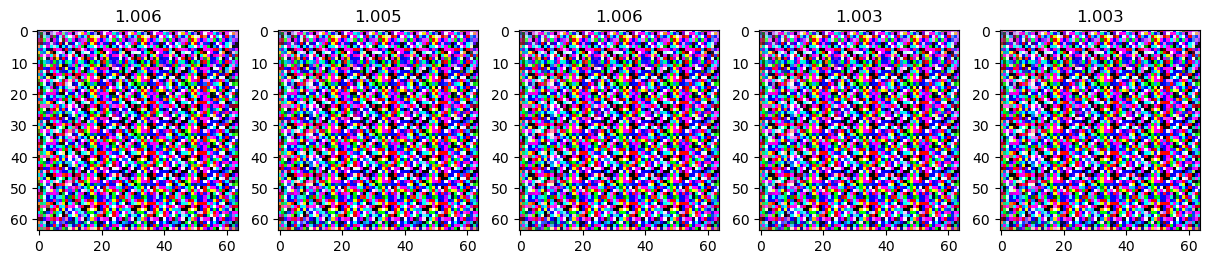

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\user\AppData\Local\Temp\ipykernel_8580\975475512.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


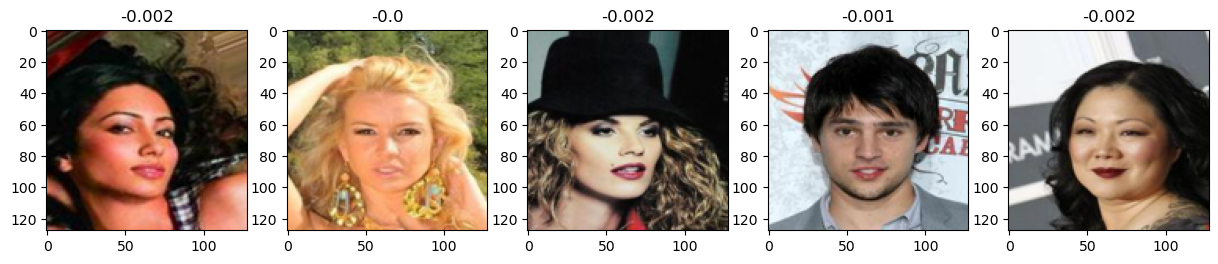

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

<Figure size 500x200 with 0 Axes>

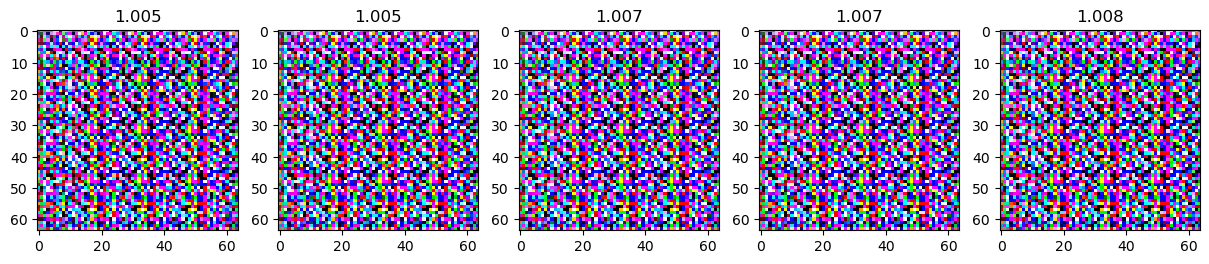

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


C:\Users\user\AppData\Local\Temp\ipykernel_8580\975475512.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


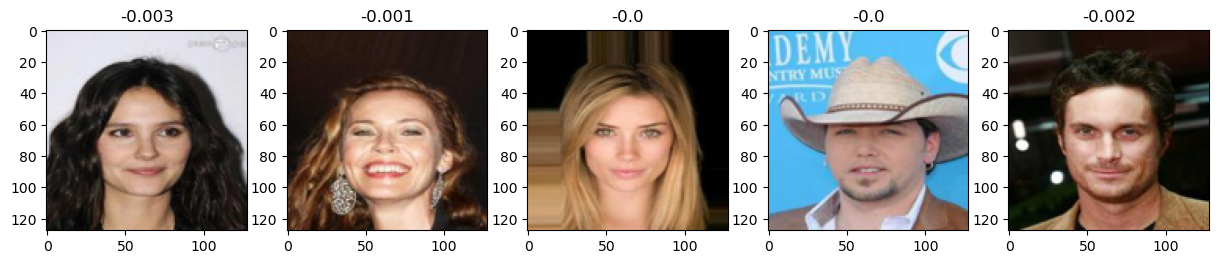

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

<Figure size 500x200 with 0 Axes>

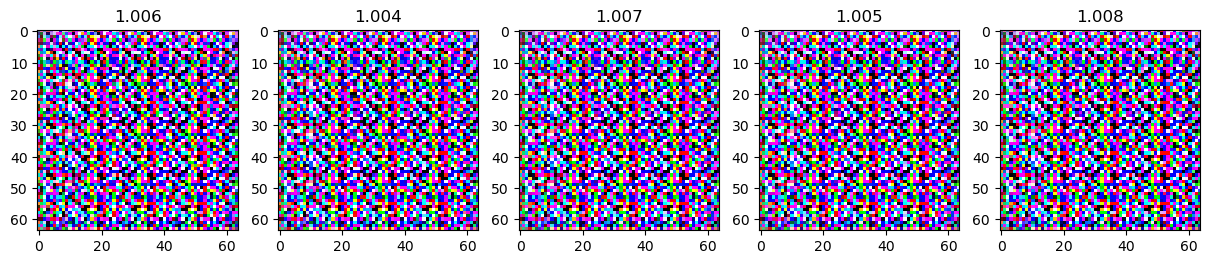

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

C:\Users\user\AppData\Local\Temp\ipykernel_8580\975475512.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


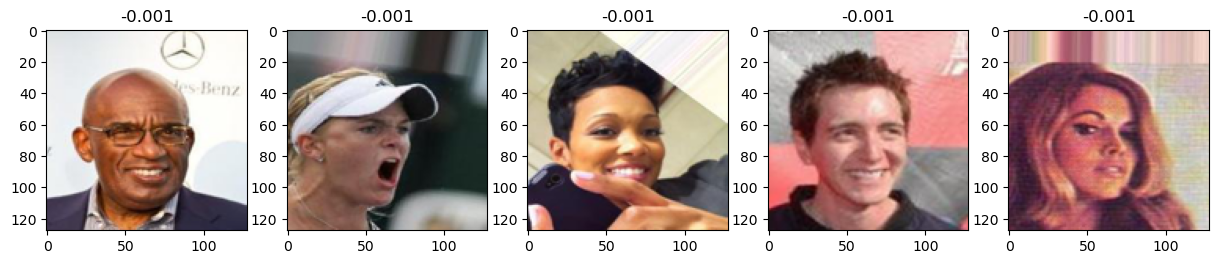

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


KeyboardInterrupt: 

In [42]:
# number of discriminator updates per alternating training iteration
DISC_UPDATES = 1  #Can try other values 
# number of generator updates per alternating training iteration
GEN_UPDATES = 2 #Can try other values

def run_training(generator, discriminator, gan, df, start_it=0, num_epochs=1000):

    SPATIAL_DIM = 128

    # helper function for selecting 'size' real images
    # and downscaling them to lower dimension SPATIAL_DIM
    def get_real_images(df, size, SPATIAL_DIM):
        # Randomly shuffle and select 'size' images
        cur_files = df.sample(frac=1).iloc[:size]

        # Prepare empty array to hold images
        X = np.empty(shape=(size, SPATIAL_DIM, SPATIAL_DIM, 3))

        for i in range(size):
            file_id = cur_files.iloc[i]['image_id']  # e.g., '000001.jpg'
            full_path = os.path.join(image_dir, file_id)

            img = Image.open(full_path).convert("RGB")
            img = img.resize((SPATIAL_DIM, SPATIAL_DIM))
            img = np.array(img).astype(np.float32) / 127.5 - 1.0  # Normalize to [-1, 1]
            X[i] = img

        return X
  
    # lists for storing loss
    avg_loss_discriminator = []
    avg_loss_generator = []
    total_it = start_it

    # main training loop
    for epoch in range(num_epochs):
        
        loss_discriminator = []
        loss_generator = []
        for it in range(200): 
            
            #### Discriminator training loop ####
            for i in range(DISC_UPDATES): 
                imgs_real = get_real_images(df, BATCH_SIZE_GAN, SPATIAL_DIM)
                noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
                imgs_fake = generator.predict(noise)
                d_loss_real = discriminator.train_on_batch(imgs_real, np.ones([BATCH_SIZE_GAN]))[1]
                d_loss_fake = discriminator.train_on_batch(imgs_fake, np.zeros([BATCH_SIZE_GAN]))[1]

            # display some fake images
            if total_it % PROGRESS_INTERVAL == 0:
                plt.figure(figsize=(5,2))
                num_vis = min(BATCH_SIZE_GAN, 5)
                imgs_real = get_real_images(df, num_vis, SPATIAL_DIM)
                noise = np.random.randn(num_vis, LATENT_DIM_GAN)
                imgs_fake = generator.predict(noise)
                for obj_plot in [imgs_fake, imgs_real]:
                    plt.figure(figsize=(num_vis * 3, 3))
                    for b in range(num_vis):
                        disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])
                        plt.subplot(1, num_vis, b + 1)
                        plt.title(str(round(disc_score, 3)))
                        plt.imshow((obj_plot[b] * 0.5 + 0.5).clip(0, 1)) 
                    if obj_plot is imgs_fake:
                        plt.savefig(os.path.join(ROOT_DIR, str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
                    plt.show()  

            #### Generator training loop ####
            loss = 0
            y = np.ones([BATCH_SIZE_GAN, 1]) 
            for j in range(GEN_UPDATES):
                noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
                loss += gan.train_on_batch(noise, y)[1]

            loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)        
            loss_generator.append(loss / GEN_UPDATES)
            total_it += 1

        clear_output(True)
        print('Epoch', epoch)
        avg_loss_discriminator.append(np.mean(loss_discriminator))
        avg_loss_generator.append(np.mean(loss_generator))
        plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
        plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
        plt.legend(['discriminator loss', 'generator loss'])
        plt.show()

    return generator, discriminator, gan

# Call your training function
generator_celeb, discriminator_celeb, gan_celeb = run_training(
    generator_celeb, 
    discriminator_celeb, 
    gan_celeb, 
    num_epochs=500, 
    df=df_celeb
)


I just added my files to the sample notebook and tweeked the last cell. My first run was slightly blurry. I changed the spatial from 64 to 128 and added .clip to the image plot.